In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datasets import load_dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import random
from tqdm import tqdm

import time
import copy
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"L'entraînement se fera sur : {device}")

L'entraînement se fera sur : cuda


# Fonctions nécessaires

In [ ]:
def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Classe')
    plt.title('Matrice de Confusion')
    plt.show()


def evaluate_test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy finale sur le jeu de test (10,000 images) : {accuracy:.2f} %')

def train_model(model, train_loader, val_loader, epochs, patience=5):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()
    total = 0
    correct = 0
    for epoch in range(epochs):
        # Entraînement
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * correct / total
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping déclenché après {epoch+1} époques !")
                break

    total_time = time.time() - start_time
    print(f"Temps total d'entraînement : {total_time:.2f}s")
    model.load_state_dict(best_model_wts)

    return train_losses, val_losses, train_accuracies, val_accuracies



def plot_training_results(history):
    train_losses, val_losses, train_accuracies , val_accuracies = history

    plt.figure(figsize=(12, 5))

    # Courbe de Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Courbe d'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy', color='green')
    plt.plot(train_accuracies, label='Train Accuracy', color='orange')
    plt.plot()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



# Cifar 10

## Prétraitement

In [ ]:
batch_size = 64 # le réseau traite par paquets de 64 imgs au lieu de 50000 (sinon explosion de la mémoire RAM/GPU)
learning_rate = 0.001
epochs = 10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # data augmentation : recadrage aléatoire avec padding de 4 pixels
    transforms.RandomHorizontalFlip(p=0.5), # data augmentation : retournement horizontal aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1), # data augmentation : modification aléatoire de la luminosité, contraste et saturation
    transforms.ToTensor(), # img classique codée entre 0 et 255, ici on divise par 255 pour avoir entre 0 et 1 (meilleur pour l'apprentissage)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # apprentissage rapide si les données ont m=0 et sigma proche de 1 (mR, mG, mB),(sigmaR, sigmaG, sigmaB)

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # valeurs prise sur google (normalisation cifar-10)
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(full_trainset)) # 40 000
val_size = len(full_trainset) - train_size # 10 000
train_dataset, val_dataset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(f"Données chargées : Train ({len(train_dataset)}), Val ({len(val_dataset)}), Test ({len(testset)})")

Données chargées : Train (40000), Val (10000), Test (10000)


torch.Size([3, 32, 32])


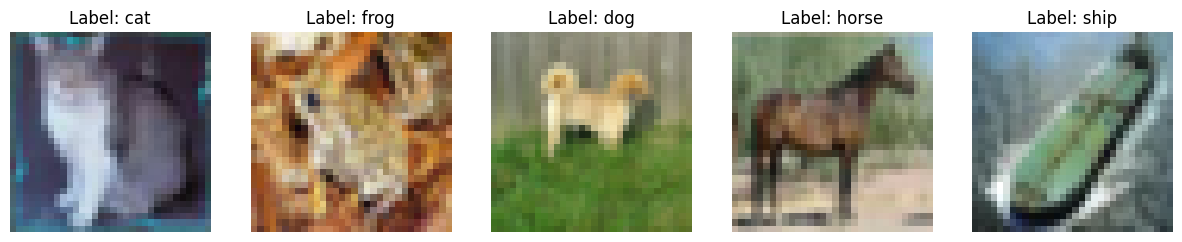

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

#images aléatoires du trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(np.shape(images[0]))
plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    imshow(images[i])
    ax.set_title(f"Label: {classes[labels[i]]}")
    plt.axis('off')

plt.show()


## Architecture VGG

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()

        # taille img entrée : 3 x 32 x 32
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Padding=1 préserve la dimension
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 4x4
        )

        # Classifieur : Fully Connected
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # transforme (batch_size, 256, 4, 4) en (batch_size, 256, 1, 1)
            nn.Flatten(),
            #nn.Linear(256 * 8 * 8, 512),
            #nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

vgg = VGG(num_classes=10).to(device)
print(f"Nombre de paramètres : {sum(p.numel() for p in vgg.parameters() if p.requires_grad)}")

Nombre de paramètres : 539786


### Entraînement

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=learning_rate, weight_decay=1e-4) #pénalité L2 pour éviter l'overfitting
#optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) #5e-4
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_vgg = train_model(vgg, trainloader, valloader, epochs=50, patience=10)


import os
os.makedirs('models', exist_ok=True)
save_path = 'models/vgg_cifar10_final.pth'
torch.save(vgg.state_dict(), save_path)

print(f"Modèle sauvegardé avec succès ici : {save_path}")

Epoch [1/50] Train Loss: 1.5443 | Val Loss: 1.2325 | Train Acc: 42.98% | Val Acc: 54.74%
Epoch [2/50] Train Loss: 1.1696 | Val Loss: 1.1059 | Train Acc: 57.66% | Val Acc: 60.49%
Epoch [3/50] Train Loss: 1.0088 | Val Loss: 1.2611 | Train Acc: 63.50% | Val Acc: 57.87%
Epoch [4/50] Train Loss: 0.9098 | Val Loss: 0.9638 | Train Acc: 66.13% | Val Acc: 66.14%
Epoch [5/50] Train Loss: 0.8388 | Val Loss: 1.0602 | Train Acc: 70.10% | Val Acc: 61.83%
Epoch [6/50] Train Loss: 0.7743 | Val Loss: 0.7190 | Train Acc: 70.86% | Val Acc: 75.29%
Epoch [7/50] Train Loss: 0.7259 | Val Loss: 0.6648 | Train Acc: 75.06% | Val Acc: 76.77%
Epoch [8/50] Train Loss: 0.6817 | Val Loss: 0.9538 | Train Acc: 76.75% | Val Acc: 68.15%
Epoch [9/50] Train Loss: 0.6501 | Val Loss: 0.6882 | Train Acc: 75.84% | Val Acc: 76.51%
Epoch [10/50] Train Loss: 0.6228 | Val Loss: 0.6506 | Train Acc: 78.45% | Val Acc: 77.63%
Epoch [11/50] Train Loss: 0.5940 | Val Loss: 0.6096 | Train Acc: 79.21% | Val Acc: 78.87%
Epoch [12/50] Train

### Résultats

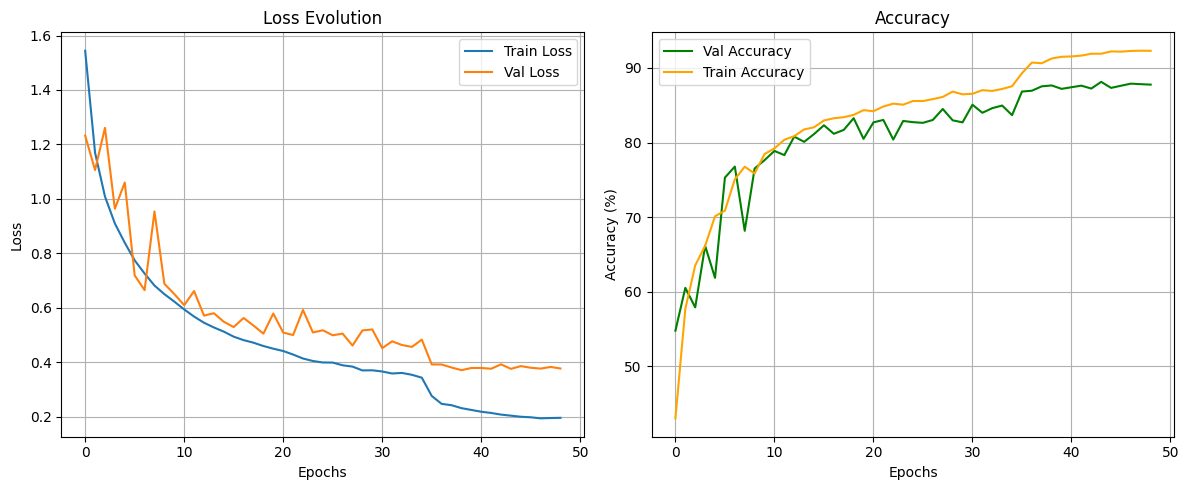

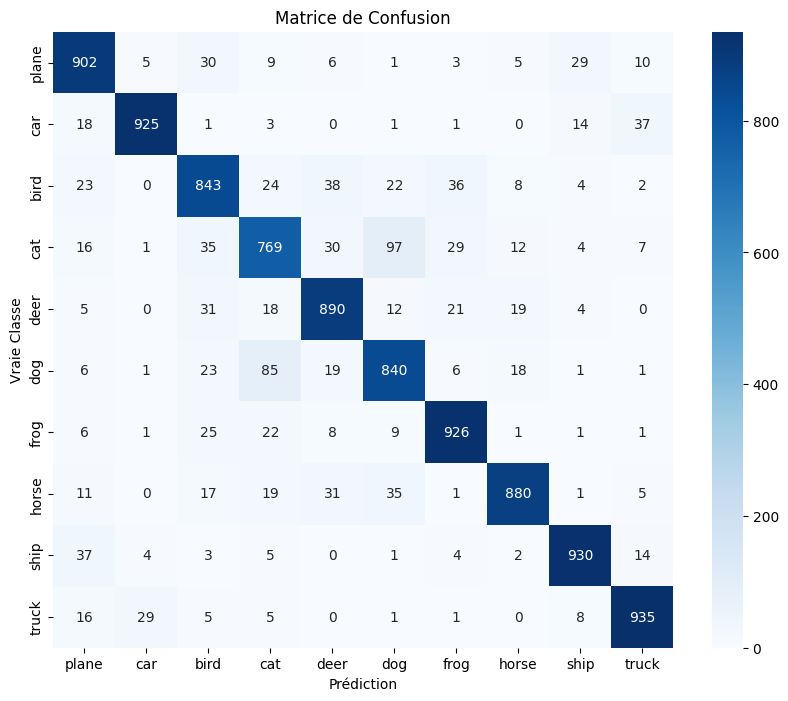

Accuracy finale sur le jeu de test (10,000 images) : 88.40 %


In [ ]:
plot_training_results(history_vgg)
plot_confusion_matrix(vgg, testloader, classes)
evaluate_test_accuracy(vgg, testloader, device)



## Architecture RESNET

#### archi modif

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # F(x) + x
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.in_channels = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer(32, 2, stride=1)
        self.layer2 = self._make_layer(64, 2, stride=2)
        self.layer3 = self._make_layer(128, 2, stride=2)
        self.layer4 = self._make_layer(256, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Ajout de Dropout avant la couche finale
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # On "éteint" 50% des neurones aléatoirement
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        out = self.classifier(out)
        return out

resnet = SimpleResNet(num_classes=10).to(device)

print(f"Modèle : ResNet Simplifié")
print(f"Nombre de paramètres : {sum(p.numel() for p in resnet.parameters() if p.requires_grad):,}")

Modèle : ResNet Simplifié
Nombre de paramètres : 2,797,610


### Entraînement

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_resnet = train_model(resnet, trainloader, valloader, epochs=50, patience=10)


import os
os.makedirs('models', exist_ok=True)
save_path = 'models/resnet_cifar10_final.pth'
torch.save(resnet.state_dict(), save_path)

Epoch [1/50] Train Loss: 0.2055 | Val Loss: 0.4255 | Train Acc: 92.78% | Val Acc: 86.82%
Epoch [2/50] Train Loss: 0.2538 | Val Loss: 0.4011 | Train Acc: 90.32% | Val Acc: 87.09%
Epoch [3/50] Train Loss: 0.2684 | Val Loss: 0.3860 | Train Acc: 90.14% | Val Acc: 87.65%
Epoch [4/50] Train Loss: 0.2807 | Val Loss: 0.4389 | Train Acc: 89.79% | Val Acc: 85.51%
Epoch [5/50] Train Loss: 0.2802 | Val Loss: 0.4091 | Train Acc: 89.31% | Val Acc: 86.22%
Epoch [6/50] Train Loss: 0.2760 | Val Loss: 0.4338 | Train Acc: 89.55% | Val Acc: 84.97%
Epoch [7/50] Train Loss: 0.2757 | Val Loss: 0.3880 | Train Acc: 89.43% | Val Acc: 87.23%
Epoch [8/50] Train Loss: 0.1661 | Val Loss: 0.2858 | Train Acc: 92.92% | Val Acc: 90.55%
Epoch [9/50] Train Loss: 0.1286 | Val Loss: 0.2800 | Train Acc: 94.61% | Val Acc: 91.24%
Epoch [10/50] Train Loss: 0.1113 | Val Loss: 0.2828 | Train Acc: 95.18% | Val Acc: 91.13%
Epoch [11/50] Train Loss: 0.1038 | Val Loss: 0.2804 | Train Acc: 95.37% | Val Acc: 91.36%
Epoch [12/50] Train

### Résultats

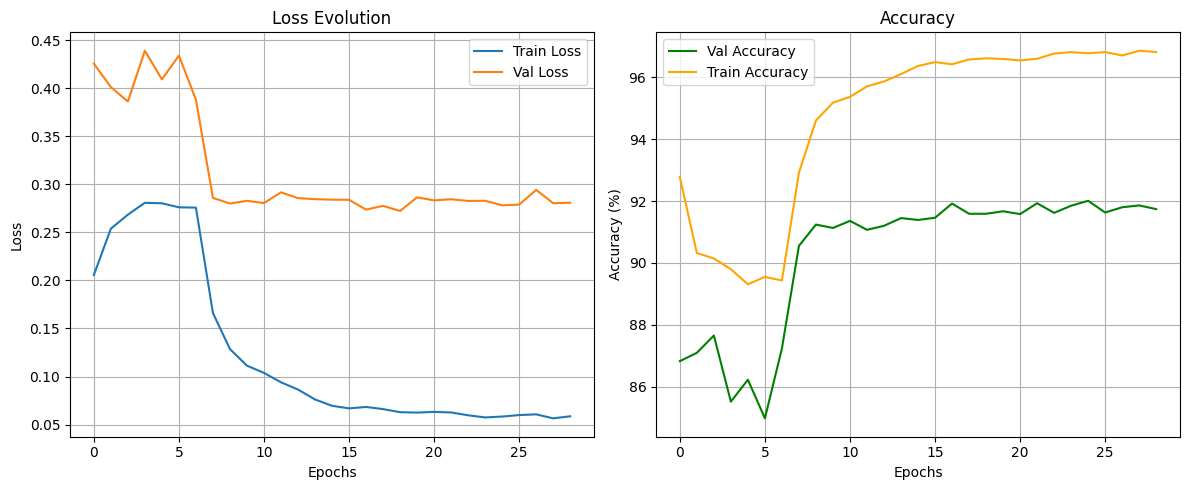

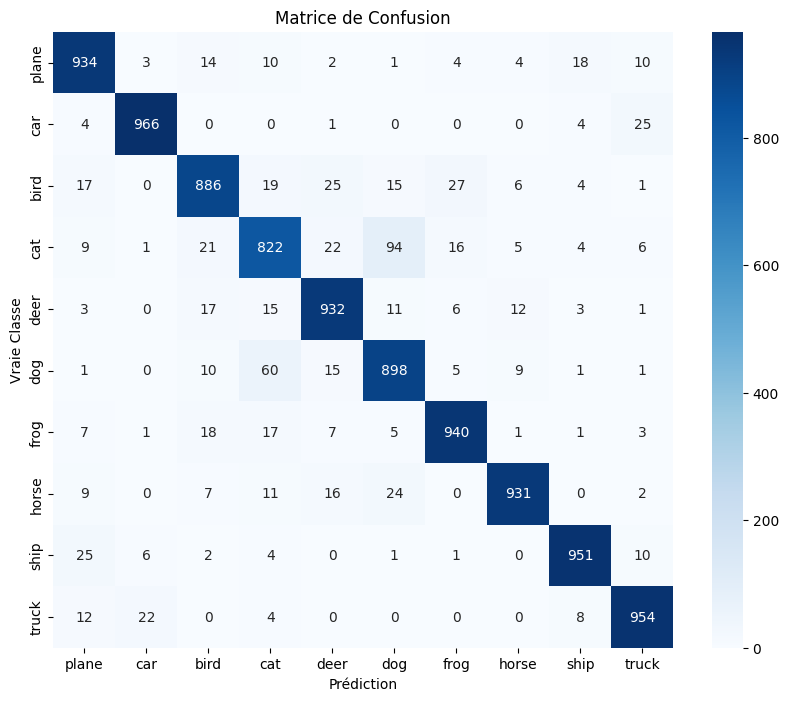

Accuracy finale sur le jeu de test (10,000 images) : 92.14 %


In [ ]:
plot_training_results(history_resnet)
plot_confusion_matrix(resnet, testloader, classes)
evaluate_test_accuracy(resnet, testloader, device)

# ImageNet

### Prétraitement

In [ ]:
class HFDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']
        label = item['label']

        # Conversion forcée en RGB (certaines images sont en N&B)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Chargement de Tiny ImageNet...")
ds = load_dataset("zh-plus/tiny-imagenet")

batch_size = 64 # le réseau traite par paquets de 64 imgs au lieu de 50000 (sinon explosion de la mémoire RAM/GPU)
learning_rate = 0.001
epochs = 10

transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4), # data augmentation : recadrage aléatoire avec padding de 4 pixels
    transforms.RandomHorizontalFlip(p=0.5), # data augmentation : retournement horizontal aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1), # data augmentation : modification aléatoire de la luminosité, contraste et saturation
    transforms.ToTensor(), # img classique codée entre 0 et 255, ici on divise par 255 pour avoir entre 0 et 1 (meilleur pour l'apprentissage)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # apprentissage rapide si les données ont m=0 et sigma proche de 1 (mR, mG, mB),(sigmaR, sigmaG, sigmaB)

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # valeurs prise sur google (normalisation cifar-10)
])


full_train_dataset = HFDatasetWrapper(ds['train'], transform=transform_train)
test_dataset = HFDatasetWrapper(ds['valid'], transform=transform_test)

val_size = 10000
train_size = len(full_train_dataset) - val_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Données prêtes : Train ({len(train_dataset)}), Val ({len(val_dataset)}), Test ({len(test_dataset)})")

Chargement de Tiny ImageNet...
Données prêtes : Train (90000), Val (10000), Test (10000)


### Architecture VGG


In [ ]:
class VGG_TinyImageNet(nn.Module):
    def __init__(self, num_classes=200):
        super(VGG_TinyImageNet, self).__init__()

        # taille img entrée : 3 x 32 x 32
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # Padding=1 préserve la dimension
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 16x16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 8x8

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 4x4
        )

        # Classifieur : Fully Connected
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

vgg_tiny = VGG_TinyImageNet(num_classes=200).to(device)
print(f"Nombre de paramètres : {sum(p.numel() for p in vgg_tiny.parameters() if p.requires_grad)}")

Nombre de paramètres : 2246088


#### Entraînement

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_tiny.parameters(), lr=learning_rate, weight_decay=1e-4) # pénalité L2 pour éviter l'overfitting
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_vgg_tiny = train_model(vgg_tiny, trainloader, valloader, epochs=20, patience=5)


Epoch [1/20] Train Loss: 4.5303 | Val Loss: 4.1915 | Train Acc: 6.86% | Val Acc: 10.08%
Epoch [2/20] Train Loss: 3.9374 | Val Loss: 3.7704 | Train Acc: 13.53% | Val Acc: 16.74%
Epoch [3/20] Train Loss: 3.6789 | Val Loss: 3.5046 | Train Acc: 17.98% | Val Acc: 21.28%
Epoch [4/20] Train Loss: 3.4844 | Val Loss: 3.4478 | Train Acc: 21.38% | Val Acc: 23.56%
Epoch [5/20] Train Loss: 3.3243 | Val Loss: 3.9008 | Train Acc: 24.32% | Val Acc: 18.53%
Epoch [6/20] Train Loss: 3.2005 | Val Loss: 3.1849 | Train Acc: 25.85% | Val Acc: 27.83%
Epoch [7/20] Train Loss: 3.0929 | Val Loss: 3.1215 | Train Acc: 28.64% | Val Acc: 29.61%
Epoch [8/20] Train Loss: 3.0049 | Val Loss: 2.9697 | Train Acc: 30.25% | Val Acc: 30.95%
Epoch [9/20] Train Loss: 2.9307 | Val Loss: 2.8651 | Train Acc: 31.72% | Val Acc: 33.93%
Epoch [10/20] Train Loss: 2.8713 | Val Loss: 2.7836 | Train Acc: 32.97% | Val Acc: 35.94%
Epoch [11/20] Train Loss: 2.8122 | Val Loss: 2.7060 | Train Acc: 34.34% | Val Acc: 37.15%
Epoch [12/20] Train 

#### Résultats

Modèle sauvegardé avec succès ici : models/vgg_tiny_final.pth


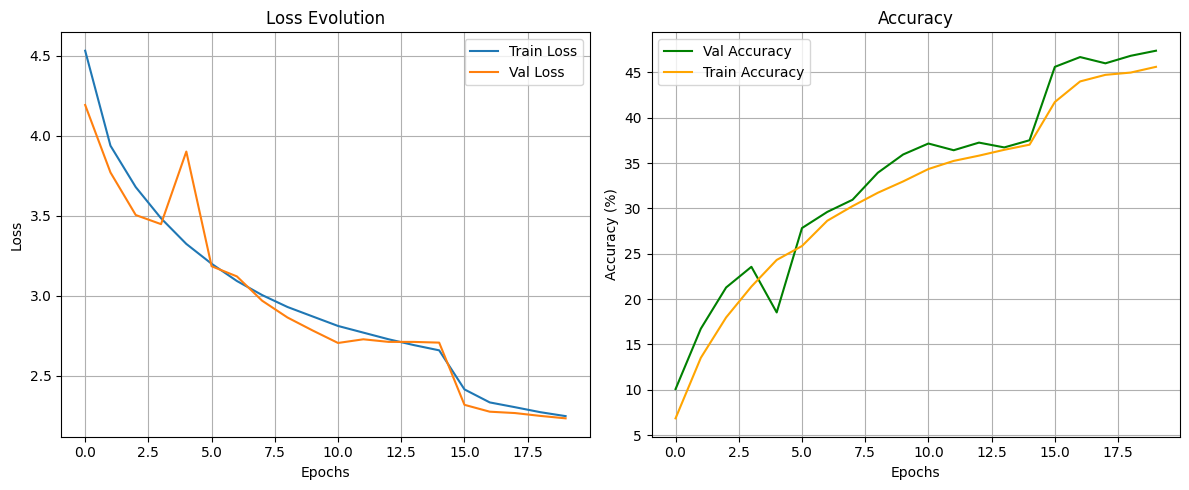

Accuracy finale sur le jeu de test (10,000 images) : 47.45 %


In [ ]:
import os
os.makedirs('models', exist_ok=True)
save_path = 'models/vgg_tiny_final.pth'
torch.save(vgg_tiny.state_dict(), save_path)

print(f"Modèle sauvegardé avec succès ici : {save_path}")
plot_training_results(history_vgg_tiny)
evaluate_test_accuracy(vgg_tiny, testloader, device)

### Architecture RESNET

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # F(x) + x
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleResNet_tiny(nn.Module):
    def __init__(self, num_classes=200):
        super(SimpleResNet_tiny, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        #Ajout de Dropout avant la couche finale
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # On "éteint" 50% des neurones aléatoirement
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        out = self.classifier(out)
        return out

resnet_tiny = SimpleResNet_tiny(num_classes=200).to(device)

print(f"Modèle : ResNet Simplifié")
print(f"Nombre de paramètres : {sum(p.numel() for p in resnet_tiny.parameters() if p.requires_grad):,}")

Modèle : ResNet Simplifié
Nombre de paramètres : 11,271,432


#### Entraînement

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_tiny.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_resnet_tiny = train_model(resnet_tiny, trainloader, valloader, epochs=20, patience=5)


import os
os.makedirs('models', exist_ok=True)
save_path = 'models/resnet_tiny_final.pth'
torch.save(resnet_tiny.state_dict(), save_path)

Epoch [1/20] Train Loss: 4.7077 | Val Loss: 4.2617 | Train Acc: 4.90% | Val Acc: 9.11%
Epoch [2/20] Train Loss: 4.0354 | Val Loss: 3.8466 | Train Acc: 11.38% | Val Acc: 15.67%
Epoch [3/20] Train Loss: 3.6390 | Val Loss: 3.3816 | Train Acc: 17.55% | Val Acc: 22.62%
Epoch [4/20] Train Loss: 3.3584 | Val Loss: 3.3289 | Train Acc: 22.69% | Val Acc: 24.19%
Epoch [5/20] Train Loss: 3.1587 | Val Loss: 3.0087 | Train Acc: 26.11% | Val Acc: 29.29%
Epoch [6/20] Train Loss: 2.9950 | Val Loss: 2.8424 | Train Acc: 29.63% | Val Acc: 33.52%
Epoch [7/20] Train Loss: 2.8588 | Val Loss: 2.7769 | Train Acc: 32.44% | Val Acc: 34.69%
Epoch [8/20] Train Loss: 2.7516 | Val Loss: 2.6425 | Train Acc: 34.54% | Val Acc: 37.34%
Epoch [9/20] Train Loss: 2.6566 | Val Loss: 2.5908 | Train Acc: 36.50% | Val Acc: 38.17%
Epoch [10/20] Train Loss: 2.5702 | Val Loss: 2.5030 | Train Acc: 38.18% | Val Acc: 40.15%
Epoch [11/20] Train Loss: 2.4893 | Val Loss: 2.4495 | Train Acc: 40.02% | Val Acc: 41.30%
Epoch [12/20] Train L

KeyboardInterrupt: 

#### Résultats

In [ ]:
plot_training_results(history_resnet_tiny)
evaluate_test_accuracy(resnet_tiny, testloader, device)

